In [39]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
import pcalg
import networkx as nx

In [40]:
DATA_FILE = "./data/20200807_user-db_cpu-load_03.json"
TARGET_DATA = {"containers": ["container_cpu_usage_seconds_total", "container_fs_io_current", "container_memory_working_set_bytes", "container_network_receive_bytes_total", "container_network_transmit_bytes_total"],
               "services": ["throughput", "latency"]}
               #"nodes": ["node_cpu_seconds_total", "node_disk_io_now", "node_filesystem_avail_bytes", "node_memory_MemAvailable_bytes", "node_network_receive_bytes_total", "node_network_transmit_bytes_total"]}

raw_data = pd.read_json(DATA_FILE)
raw_data
#for s in raw_data["services"]["carts"]:
#    print(s["metric_name"])
#for c in raw_data["containers"]["carts"]:
#    print(c["metric_name"])

,containers,nodes,services
catalogue,"[{'container_name': 'catalogue', 'metric_name'...",NaN,"[{'service_name': 'catalogue', 'metric_name': ..."
catalogue-db,"[{'container_name': 'catalogue-db', 'metric_na...",NaN,NaN
orders,"[{'container_name': 'orders', 'metric_name': '...",NaN,"[{'service_name': 'orders', 'metric_name': 'th..."
orders-db,"[{'container_name': 'orders-db', 'metric_name'...",NaN,NaN
queue-master,"[{'container_name': 'queue-master', 'metric_na...",NaN,NaN
rabbitmq,"[{'container_name': 'rabbitmq', 'metric_name':...",NaN,NaN
user-db,"[{'container_name': 'user-db', 'metric_name': ...",NaN,NaN
carts,"[{'container_name': 'carts', 'metric_name': 'c...",NaN,"[{'service_name': 'carts', 'metric_name': 'thr..."
front-end,"[{'container_name': 'front-end', 'metric_name'...",NaN,"[{'service_name': 'front-end', 'metric_name': ..."
payment,"[{'container_name': 'payment', 'metric_name': ...",NaN,"[{'service_name': 'payment', 'metric_name': 't..."


In [41]:
# Prepare data matrix
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target]:
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1])].replace("gke-microservices-experi-default-pool-", "")
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float64)[:, 1]
data_df

,c-catalogue_fs_io_current,c-catalogue_memory_working_set_bytes,c-catalogue_cpu_usage_seconds_total,c-catalogue-db_fs_io_current,c-catalogue-db_memory_working_set_bytes,c-catalogue-db_cpu_usage_seconds_total,c-orders_fs_io_current,c-orders_memory_working_set_bytes,c-orders_cpu_usage_seconds_total,c-orders-db_fs_io_current,...,s-carts_throughput,s-carts_latency,s-front-end_throughput,s-front-end_latency,s-payment_throughput,s-payment_latency,s-shipping_throughput,s-shipping_latency,s-user_throughput,s-user_latency
0,0.0,10997760.0,0.014953,0.0,212324352.0,0.011705,0.0,305147904.0,0.048692,0.0,...,29.400000,0.003953,67.244444,0.057726,7.044444,0.000231,6.266667,0.000626,46.733333,0.005930
1,0.0,10997760.0,0.015208,0.0,212426752.0,0.010085,0.0,305221632.0,0.049336,0.0,...,30.088889,0.004573,69.644444,0.058566,7.288889,0.000250,6.444301,0.000615,48.333333,0.005505
2,0.0,10997760.0,0.015272,0.0,212324352.0,0.012003,0.0,305229824.0,0.042765,0.0,...,31.622222,0.004739,70.866667,0.058216,7.333333,0.000253,6.688889,0.000613,52.244444,0.004994
3,0.0,10997760.0,0.017152,0.0,212344832.0,0.013195,0.0,305274880.0,0.057000,0.0,...,35.933333,0.005311,80.311111,0.052784,8.555556,0.000238,7.533333,0.000612,60.111111,0.004145
4,0.0,11001856.0,0.018619,0.0,212463616.0,0.014956,0.0,305250304.0,0.066128,0.0,...,39.554677,0.005162,89.311111,0.046364,9.466667,0.000238,8.266850,0.000637,64.955556,0.003605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.0,11108352.0,0.012987,0.0,212717568.0,0.011001,0.0,305344512.0,0.045149,0.0,...,27.709880,0.004465,64.088889,0.085845,6.850991,0.000253,6.311111,0.000636,44.888889,0.025687
237,0.0,11108352.0,0.012911,0.0,212574208.0,0.009138,0.0,305307648.0,0.043592,0.0,...,27.400000,0.004657,63.444444,0.088293,6.755856,0.000230,6.088618,0.000624,44.022222,0.025879
238,0.0,11108352.0,0.012884,0.0,212586496.0,0.010925,0.0,305209344.0,0.043687,0.0,...,26.933333,0.004589,63.288889,0.087193,6.844597,0.000230,6.378203,0.000634,44.022222,0.026522
239,0.0,11108352.0,0.011447,0.0,212615168.0,0.010871,0.0,305291264.0,0.043441,0.0,...,27.216779,0.004689,62.088889,0.088281,6.688889,0.000230,6.000000,0.000672,44.422222,0.026266


In [42]:
labels = {}
for i in range(len(data_df.columns)):
    labels[i] = data_df.columns[i]
labels

{0: 'c-catalogue_fs_io_current',
 1: 'c-catalogue_memory_working_set_bytes',
 2: 'c-catalogue_cpu_usage_seconds_total',
 3: 'c-catalogue-db_fs_io_current',
 4: 'c-catalogue-db_memory_working_set_bytes',
 5: 'c-catalogue-db_cpu_usage_seconds_total',
 6: 'c-orders_fs_io_current',
 7: 'c-orders_memory_working_set_bytes',
 8: 'c-orders_cpu_usage_seconds_total',
 9: 'c-orders-db_fs_io_current',
 10: 'c-orders-db_memory_working_set_bytes',
 11: 'c-orders-db_cpu_usage_seconds_total',
 12: 'c-queue-master_fs_io_current',
 13: 'c-queue-master_memory_working_set_bytes',
 14: 'c-queue-master_cpu_usage_seconds_total',
 15: 'c-rabbitmq_fs_io_current',
 16: 'c-rabbitmq_memory_working_set_bytes',
 17: 'c-rabbitmq_cpu_usage_seconds_total',
 18: 'c-user-db_fs_io_current',
 19: 'c-user-db_memory_working_set_bytes',
 20: 'c-user-db_cpu_usage_seconds_total',
 21: 'c-carts_fs_io_current',
 22: 'c-carts_memory_working_set_bytes',
 23: 'c-carts_cpu_usage_seconds_total',
 24: 'c-front-end_fs_io_current',
 25:

In [43]:
containers_list = []
for v in labels.values():
    if re.match("^c-", v):
        container_name = v.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
print(containers_list)

containers_metrics = {}
for c in containers_list:
    nodes = []
    for k, v in labels.items():
        if re.match("^c-{}_".format(c), v):
            nodes.append(k)
    containers_metrics[c] = nodes
print(containers_metrics)

['catalogue', 'catalogue-db', 'orders', 'orders-db', 'queue-master', 'rabbitmq', 'user-db', 'carts', 'front-end', 'payment', 'shipping', 'user']
{'catalogue': [0, 1, 2], 'catalogue-db': [3, 4, 5], 'orders': [6, 7, 8], 'orders-db': [9, 10, 11], 'queue-master': [12, 13, 14], 'rabbitmq': [15, 16, 17], 'user-db': [18, 19, 20], 'carts': [21, 22, 23], 'front-end': [24, 25, 26], 'payment': [27, 28, 29], 'shipping': [30, 31, 32], 'user': [33, 34, 35]}


## 事前知識

In [44]:
# Communicating dependency
com_deps = {
    "front-end": ["orders", "carts", "user", "catalogue"],
    "catalogue": ["front-end", "catalogue-db"],
    "catalogue-db": ["catalogue"],
    "orders": ["front-end", "orders-db", "carts", "user", "payement", "shipping"],
    "orders-db": ["orders"],
    "user": ["front-end", "user-db", "orders"],
    "user-db": ["user"],
    "payment": ["orders"],
    "shipping": ["orders", "rabbitmq"],
    "queue-master": ["rabbitmq"],
    "rabbitmq": ["shipping", "queue-master"],
    "carts": ["front-end", "carts-db", "orders"],
    "carts-db": ["carts"]
}
# Share hosts
container_hosts = {
    "front-end": "66a015a7-i5rl",
    "catalogue": "66a015a7-w0i8",
    "catalogue-db": "66a015a7-w0i8",
    "orders": "66a015a7-w0i8",
    "orders-db": "66a015a7-eq47",
    "user": "66a015a7-i5rl",
    "user-db": "66a015a7-w0i8",
    "payment": "66a015a7-g7qj",
    "shipping": "66a015a7-g7qj",
    "queue-master": "66a015a7-eq47",
    "rabbitmq": "66a015a7-w0i8",
    "carts": "66a015a7-g7qj",
    "carts-db": "66a015a7-eq47"
}

In [45]:
no_deps_container_pair = []
for i, j in combinations(containers_list, 2):
    if j not in com_deps[i] and container_hosts[i] != container_hosts[j]:
        no_deps_container_pair.append([i, j])
print(len(no_deps_container_pair))
print(no_deps_container_pair)

41
[['catalogue', 'orders-db'], ['catalogue', 'queue-master'], ['catalogue', 'carts'], ['catalogue', 'payment'], ['catalogue', 'shipping'], ['catalogue', 'user'], ['catalogue-db', 'orders-db'], ['catalogue-db', 'queue-master'], ['catalogue-db', 'carts'], ['catalogue-db', 'front-end'], ['catalogue-db', 'payment'], ['catalogue-db', 'shipping'], ['catalogue-db', 'user'], ['orders', 'queue-master'], ['orders', 'payment'], ['orders-db', 'rabbitmq'], ['orders-db', 'user-db'], ['orders-db', 'carts'], ['orders-db', 'front-end'], ['orders-db', 'payment'], ['orders-db', 'shipping'], ['orders-db', 'user'], ['queue-master', 'user-db'], ['queue-master', 'carts'], ['queue-master', 'front-end'], ['queue-master', 'payment'], ['queue-master', 'shipping'], ['queue-master', 'user'], ['rabbitmq', 'carts'], ['rabbitmq', 'front-end'], ['rabbitmq', 'payment'], ['rabbitmq', 'user'], ['user-db', 'carts'], ['user-db', 'front-end'], ['user-db', 'payment'], ['user-db', 'shipping'], ['carts', 'user'], ['front-end'

In [46]:
no_paths = []
for pair in no_deps_container_pair:
    for i in containers_metrics[pair[0]]:
        for j in containers_metrics[pair[1]]:
            no_paths.append([i, j])
print(len(no_paths))

369


In [47]:
# Prepare init graph
init_g = nx.Graph()
node_ids = range(len(data_df.columns))
init_g.add_nodes_from(node_ids)
for (i, j) in combinations(node_ids, 2):
    init_g.add_edge(i, j)
print(init_g.number_of_edges())
for no_path in no_paths:
    init_g.remove_edge(no_path[0], no_path[1])
print(init_g.number_of_edges())
#agraph = nx.nx_agraph.to_agraph(init_g).draw(prog='sfdp', format='png')
#Image(agraph)

1225
856


## Fisher-Z検定

In [19]:
dm = data_df.values
dm.shape

(241, 50)

In [24]:
import sys 
sys.path.append("../") 
from citest.ci_tests import ci_test_gauss
cm = np.corrcoef(dm.T)

(G, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_gauss,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 corr_matrix=cm,
                                 init_graph=init_g)
G = pcalg.estimate_cpdag(skel_graph=G, sep_set=sep_set)

/Users/hi-tsuruta/go/src/github.com/tsurubee/causal-discovery/.venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hi-tsuruta/go/src/github.com/tsurubee/causal-discovery/.venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [25]:
# Exclude nodes that have no neighbors for visualization
remove_nodes = list(G.nodes)
for edge in G.edges():
    for n in edge:
        try:
            remove_nodes.remove(n)
        except ValueError:
            pass
print(remove_nodes)
G.remove_nodes_from(remove_nodes)

[0, 3, 5, 6, 9, 12, 15, 18, 21, 23, 24, 26, 27, 29, 30, 32, 33, 35]


In [26]:
G = nx.relabel_nodes(G, labels)

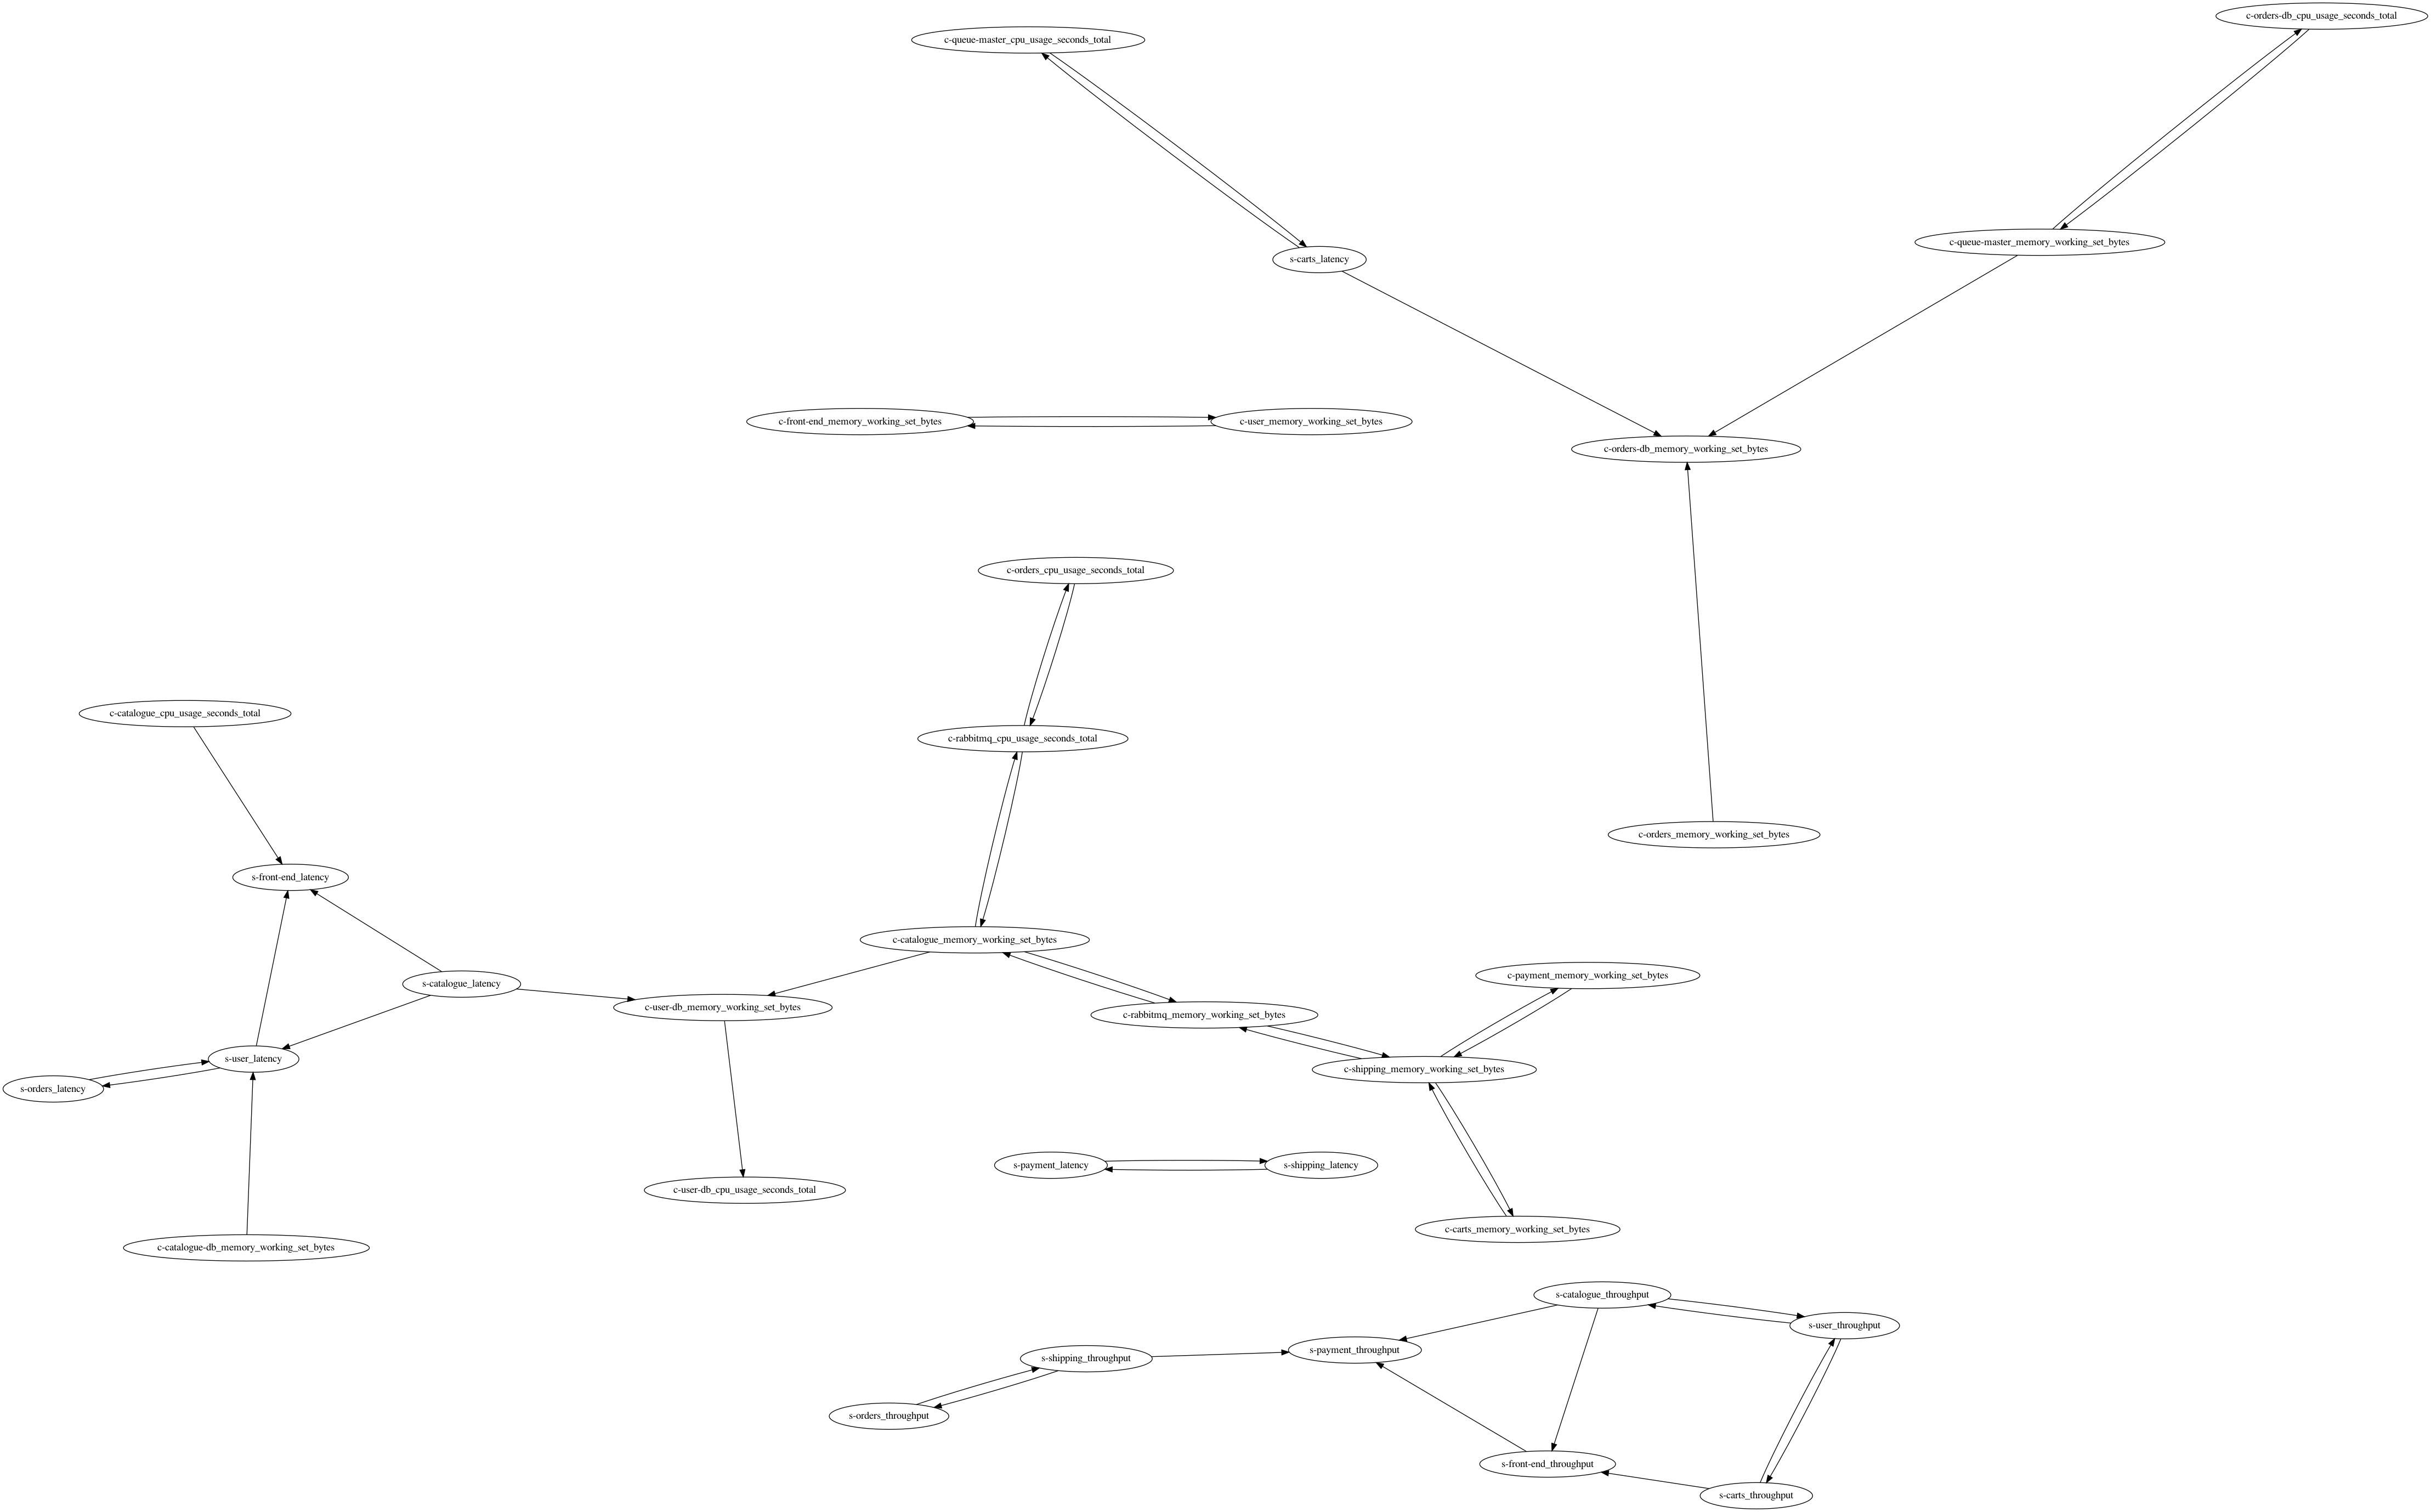

In [27]:
from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(G).draw(prog='sfdp', format='png')
Image(agraph)

## chi square test

In [48]:
# Determine the number of categories by Sturges' rule
data_size = len(data_df)
n_bins = int(np.log2(data_size) + 1)
print("Number of bins: {}".format(n_bins))

Number of bins: 8


In [49]:
disc_data_df = pd.DataFrame()
for col in data_df.columns:
    disc_data_df[col] = pd.cut(data_df[col], n_bins, labels=np.arange(0, n_bins))
disc_data_df

,c-catalogue_fs_io_current,c-catalogue_memory_working_set_bytes,c-catalogue_cpu_usage_seconds_total,c-catalogue-db_fs_io_current,c-catalogue-db_memory_working_set_bytes,c-catalogue-db_cpu_usage_seconds_total,c-orders_fs_io_current,c-orders_memory_working_set_bytes,c-orders_cpu_usage_seconds_total,c-orders-db_fs_io_current,...,s-carts_throughput,s-carts_latency,s-front-end_throughput,s-front-end_latency,s-payment_throughput,s-payment_latency,s-shipping_throughput,s-shipping_latency,s-user_throughput,s-user_latency
0,3,0,3,3,0,4,3,2,3,3,...,1,0,1,2,0,3,0,3,0,0
1,3,0,3,3,2,3,3,3,3,3,...,1,3,1,3,1,5,1,2,1,0
2,3,0,3,3,0,4,3,3,2,3,...,2,4,1,3,1,6,1,2,2,0
3,3,0,5,3,0,5,3,3,4,3,...,4,7,3,2,3,4,3,2,4,0
4,3,0,6,3,2,6,3,3,6,3,...,6,6,5,1,5,4,5,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,3,7,2,3,7,3,3,4,2,3,...,0,2,0,7,0,6,0,4,0,7
237,3,7,2,3,5,2,3,4,2,3,...,0,3,0,7,0,3,0,3,0,7
238,3,7,2,3,5,3,3,3,2,3,...,0,3,0,7,0,3,1,3,0,7
239,3,7,1,3,5,3,3,4,2,3,...,0,4,0,7,0,3,0,6,0,7


In [52]:
dm = disc_data_df.values
dm.shape

(241, 50)

In [53]:
from citest.chi_square import chi_square

(g, sep_set) = pcalg.estimate_skeleton(indep_test_func=chi_square,
                                 data_matrix=dm,
                                 alpha=0.01,
                                 init_graph=init_g)
g = pcalg.estimate_cpdag(skel_graph=g, sep_set=sep_set)

In [54]:
# Exclude nodes that have no neighbors for visualization
remove_nodes = list(g.nodes)
for edge in g.edges():
    for n in edge:
        try:
            remove_nodes.remove(n)
        except ValueError:
            pass
print(remove_nodes)
g.remove_nodes_from(remove_nodes)

[0, 3, 4, 5, 6, 7, 9, 11, 12, 15, 17, 18, 19, 20, 21, 24, 25, 27, 29, 30, 33, 34]


In [55]:
g = nx.relabel_nodes(g, labels)

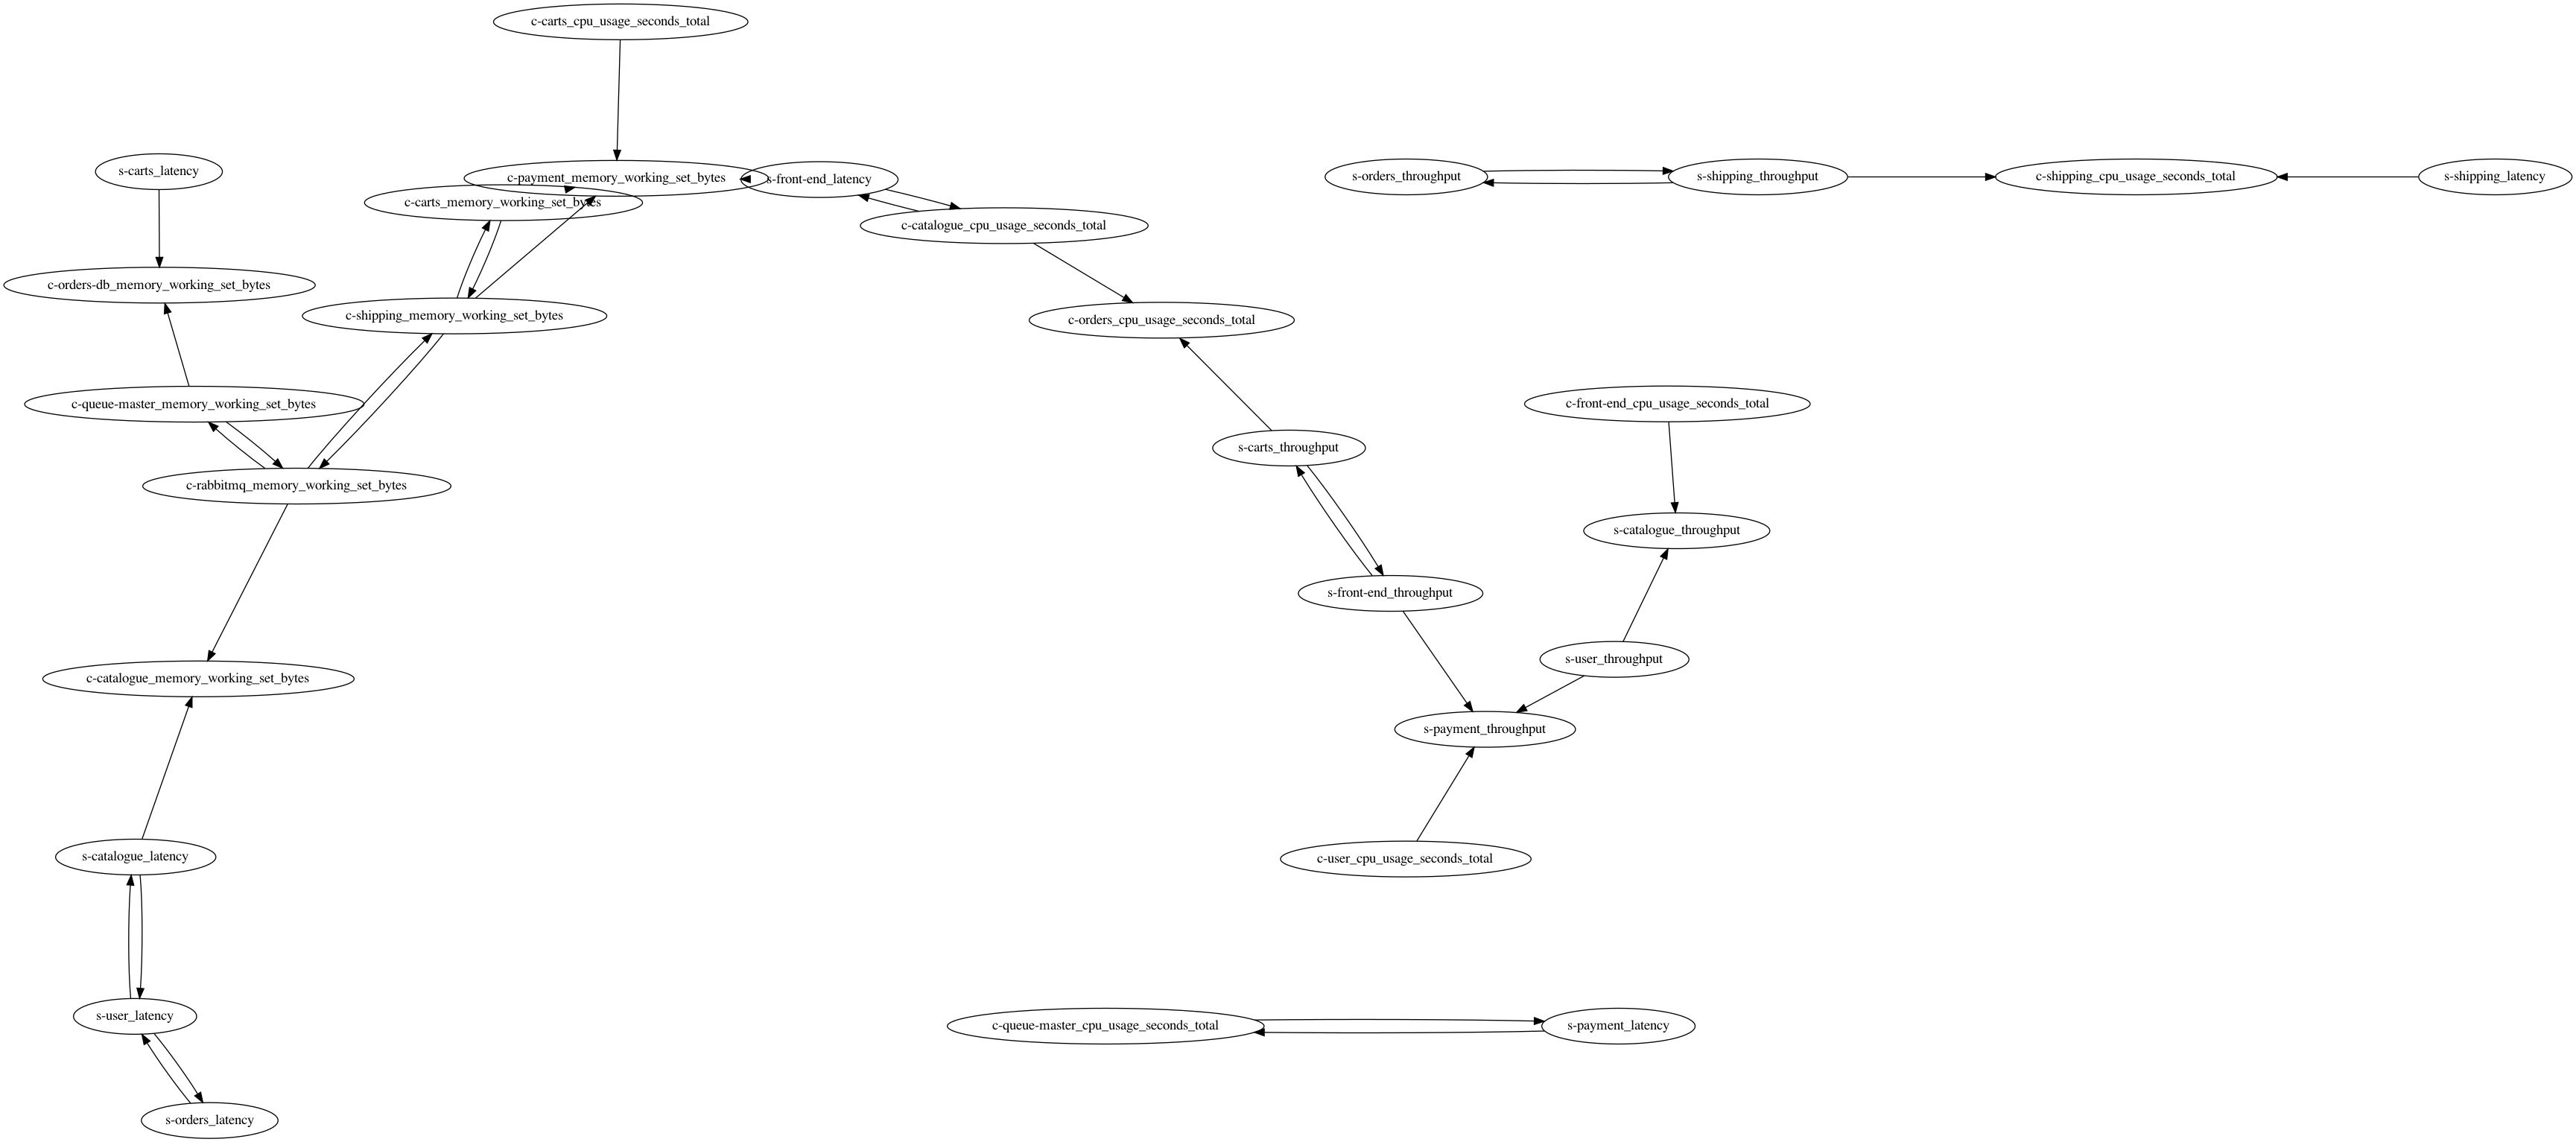

In [56]:
from IPython.display import Image, SVG, display

# prog=[‘neato’|’dot’|’twopi’|’circo’|’fdp’|’nop’] 
agraph = nx.nx_agraph.to_agraph(g).draw(prog='sfdp', format='png')
Image(agraph)